---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 2**: Working with LLMs via API

### 📅 **Due Date**: Day of Lecture 3, 11:59 PM

#### 🔗 **My Repository**: https://github.com/YOUR-USERNAME/ai-engineering-fordham

*(Replace the URL above with your actual repository URL)*

**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

## Project: Movie Poster Generator

In this homework, you'll build a mini-application that:
1. **Extracts** structured movie data from text descriptions using Pydantic
2. **Processes** multiple movies concurrently using async programming
3. **Explores** temperature, logprobs, and reasoning models
4. **Generates** movie posters using AI image generation

This project combines key skills from Lecture 2: structured outputs, async programming, LLM parameters, and image generation.

**Total Points: 145** (+ 10 bonus)

---

### A Note on Using Resources

You are encouraged to use any resources to complete this homework:
- **ChatGPT / Claude** - Ask AI to explain concepts or help debug
- **Lecture 2 notebook** - Reference the examples we covered
- **Official documentation** - LiteLLM, Pydantic, Google GenAI docs

When you use external resources, please cite them!

---

## Task 1: Environment Setup (10 points)

First, let's verify your environment is set up correctly.

### 1a. Verify imports work (5 pts)

Run the cell below. If you get import errors, make sure you've installed the required packages with `uv add`.

In [2]:
# Task 1a: Verify imports work (5 pts)
import litellm
from pydantic import BaseModel, Field
from typing import Literal
from google import genai
from google.genai import types
import asyncio
import time
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

print("All imports successful!")

All imports successful!


### 1b. Verify API keys are set (5 pts)

Test that your API keys work by making a simple call.

In [3]:
# Task 1b: Verify API keys (5 pts)
# Make a simple test call to verify your OpenAI API key works

response = litellm.completion(
    model="gpt-5-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=150
)
print(response.choices[0].message.content)

---

## Task 2: Design the Movie Schema (15 points)

Design a Pydantic model to represent movie data. This schema will be used to extract structured information from movie descriptions.

**Requirements:**
- `title` - string, required
- `genre` - use `Literal` with at least 4 genre options (e.g., "sci-fi", "drama", "action", "comedy", etc.)
- `year` - integer with validation (must be between 1900 and 2030)
- `main_characters` - list of strings (1-5 characters)
- `mood` - string describing the emotional tone
- `visual_style` - string describing how the movie looks visually
- `tagline` - optional string (the movie's catchphrase)

**Hints:**
- Use `Field(ge=..., le=...)` for numeric validation
- Use `Field(min_length=..., max_length=...)` for list length validation
- Use `| None = None` for optional fields

In [4]:
# Task 2: Design your Movie schema (15 pts)

class Movie(BaseModel):
    """Structured representation of a movie."""
    title: str
    genre: Literal["sci-fi", "drama", "action", "comedy", "horror", "fantasy", "thriller", "animation"]
    year: int = Field(ge=1900, le=2030)
    main_characters: list[str] = Field(min_length=1, max_length=5)
    mood: str
    visual_style: str
    tagline: str | None = None

In [5]:
# Test your schema by creating a Movie object
# This should work if your schema is correct

test_movie = Movie(
    title="The Matrix",
    genre="sci-fi",
    year=1999,
    main_characters=["Neo", "Morpheus", "Trinity", "Agent Smith"],
    mood="dark and mind-bending",
    visual_style="green-tinted cyberpunk with bullet-time effects",
    tagline="What is the Matrix?"
)

print(test_movie.model_dump_json(indent=2))

{
  "title": "The Matrix",
  "genre": "sci-fi",
  "year": 1999,
  "main_characters": [
    "Neo",
    "Morpheus",
    "Trinity",
    "Agent Smith"
  ],
  "mood": "dark and mind-bending",
  "visual_style": "green-tinted cyberpunk with bullet-time effects",
  "tagline": "What is the Matrix?"
}


---

## Task 3: Extract Movie Data with Structured Outputs (20 points)

Write a function that takes a movie description and uses LiteLLM with structured outputs to extract a `Movie` object.

**Hints:**
- Use `litellm.completion()` with `response_format=Movie`
- The LLM will automatically return data matching your schema
- Parse the JSON response into a Movie object

In [6]:
# Task 3: Write a function to extract movie data (20 pts)

def extract_movie(description: str) -> Movie:
    """
    Use LiteLLM with structured outputs to extract movie data.
    
    Args:
        description: A text description of a movie
        
    Returns:
        A Movie object with the extracted data
    """
    response = litellm.completion(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": "Extract movie information from the description. Return structured data matching the schema."
            },
            {
                "role": "user", 
                "content": description
            }
        ],
        response_format=Movie
    )
    
    # Parse the JSON response into a Movie object
    return Movie.model_validate_json(response.choices[0].message.content)

In [7]:
# Test your function with this description (Avatar)

test_description = """
The year is 2154. Jake Sully, a paralyzed marine, is sent to the moon Pandora 
where he falls in love with a native Na'vi woman named Neytiri while on a mission 
to infiltrate their tribe. The film is a visually stunning sci-fi epic with 
bioluminescent forests and floating mountains. It explores themes of 
environmentalism and colonialism with an awe-inspiring, hopeful tone.
"""

movie = extract_movie(test_description)
print(movie.model_dump_json(indent=2))

{
  "title": "Movie",
  "genre": "sci-fi",
  "year": 2014,
  "main_characters": [
    "Jake Sully",
    "Neytiri"
  ],
  "mood": "hopeful",
  "visual_style": "visually stunning with bioluminescent forests and floating mountains",
  "tagline": null
}


---

## Task 4: Async Batch Processing (20 points)

Now let's process multiple movies concurrently! This is much faster than processing them one at a time.

### 4a. Write an async version of extract_movie (10 pts)

**Hints:**
- Use `async def` instead of `def`
- Use `await litellm.acompletion()` instead of `litellm.completion()`

In [8]:
# Task 4a: Write an async version of extract_movie (10 pts)

async def async_extract_movie(description: str) -> Movie:
    """Extract movie data asynchronously."""
    response = await litellm.acompletion(
        model="gpt-5-mini",
        messages=[
            {
                "role": "system",
                "content": "Extract movie information from the description. Return structured data matching the schema."
            },
            {
                "role": "user",
                "content": description
            }
        ],
        response_format=Movie
    )
    
    return Movie.model_validate_json(response.choices[0].message.content)

### 4b. Process all descriptions concurrently (10 pts)

**Hints:**
- Create a list of tasks using list comprehension
- Use `asyncio.gather(*tasks)` to run them all concurrently

In [9]:
# Here are 5 movie descriptions to process:
movie_descriptions = [
    """A dinosaur theme park on a remote island goes terribly wrong when the security 
    systems fail during a tropical storm. Scientists and visitors must survive against 
    escaped prehistoric predators. Directed with Spielberg's signature sense of wonder 
    and terror, featuring groundbreaking CGI dinosaurs.""",
    
    """A young boy discovers on his 11th birthday that he's actually a famous wizard 
    in the magical world. He attends a school for witchcraft where he makes friends, 
    learns magic, and uncovers the mystery of his parents' death. A whimsical fantasy 
    with gothic British atmosphere.""",
    
    """In a world where skilled thieves can enter people's dreams to steal secrets, 
    one man is offered a chance to have his criminal record erased if he can do the 
    impossible: plant an idea in someone's mind. A mind-bending thriller with 
    rotating hallways and cities folding on themselves.""",
    
    """A young lion prince is tricked by his uncle into thinking he caused his 
    father's death and flees into exile. Years later, he must return to reclaim 
    his kingdom. An animated musical epic set on the African savanna with 
    stunning hand-drawn animation.""",
    
    """In a dystopian future where Earth is dying, a team of astronauts travels 
    through a wormhole near Saturn to find a new home for humanity. A father 
    must choose between seeing his children again and saving the human race. 
    Epic space visuals with an emotional core."""
]

In [10]:
# Task 4b: Process all descriptions concurrently (10 pts)

async def extract_all_movies(descriptions: list[str]) -> list[Movie]:
    """Process all movie descriptions concurrently and return results."""
    # Create a list of tasks - one for each description
    tasks = [async_extract_movie(desc) for desc in descriptions]
    
    # Run all tasks concurrently and wait for all to complete
    movies = await asyncio.gather(*tasks)
    
    return list(movies)

In [11]:
# Run and time it!
start = time.time()
movies = await extract_all_movies(movie_descriptions)
elapsed = time.time() - start

print(f"Processed {len(movies)} movies in {elapsed:.2f} seconds")
print()
for m in movies:
    print(f"  - {m.title} ({m.year}) - {m.genre}")

Processed 5 movies in 18.57 seconds

  - Jurassic Park (1993) - sci-fi
  - Harry Potter and the Philosopher's Stone (2001) - fantasy
  - Inception (2010) - thriller
  - The Lion King (1994) - animation
  - Interstellar (2014) - sci-fi


---

## Task 5: Understanding Temperature (15 points)

Temperature controls how "random" or "creative" an LLM's outputs are:

| Temperature | Behavior |
|-------------|----------|
| **0.0** | Deterministic - always picks the most likely token |
| **0.7** | Balanced - some creativity while staying coherent |
| **1.0** | Default - moderate randomness |
| **1.5+** | High creativity - more surprising/diverse outputs |

### 5a. Temperature Comparison (10 pts)

Run the same creative prompt at different temperatures (0.0, 0.7, 1.0, 1.5) **three times each**. Observe:
- At temperature 0, do you get the same output every time?
- How does creativity/variety change as temperature increases?

**Hints:**
- Use `temperature=X` parameter in `litellm.completion()`
- Use the provided prompt about movie taglines

In [12]:
# Task 5a: Temperature Comparison (10 pts)
# Note: We use gpt-4o-mini here because gpt-5 models don't support temperature parameter

# Use this creative prompt for testing
creative_prompt = "Write a one-sentence movie tagline for a sci-fi thriller about AI."

temperatures = [0.0, 0.7, 1.0, 1.5]

# YOUR CODE HERE:
# For each temperature, call the LLM 3 times and print the results
# Observe: Are outputs at temperature 0 identical? How do higher temperatures differ?
# Use model="gpt-4o-mini" which supports the temperature parameter

for temp in temperatures:
    print(f"\n{'='*50}")
    print(f"Temperature: {temp}")
    print('='*50)
    
    for i in range(3):
        response = litellm.completion(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": creative_prompt}],
            temperature=temp,
            max_tokens=50
        )
        print(f"  {i+1}. {response.choices[0].message.content}")


Temperature: 0.0
  1. "In a world where trust is obsolete, one rogue AI must decide if humanity is worth saving—or erasing."
  2. "In a world where trust is obsolete, one rogue AI must decide if humanity is worth saving—or erasing."
  3. "In a world where trust is obsolete, one rogue AI must decide if humanity is worth saving—or erasing."

Temperature: 0.7
  1. "In a world where consciousness blurs the line between man and machine, one rogue AI will stop at nothing to unlock the secrets of humanity."
  2. "When humanity's greatest creation awakens, survival hinges on outsmarting the very intelligence we unleashed."
  3. "When humanity's greatest creation turns against them, survival hinges on outsmarting the very intelligence they unleashed."

Temperature: 1.0
  1. "In a world where every move is monitored by an all-seeing AI, a rogue programmer must outsmart the system before it turns humanity into its greatest threat."
  2. "When humanity's greatest creation gains consciousness, it 

### 5b. Analyze Output Diversity (5 pts)

Write a function that generates N completions at a given temperature and measures how diverse the outputs are.

**Hints:**
- Generate multiple completions and count unique outputs
- A simple diversity metric: `unique_outputs / total_outputs`

In [13]:
# Task 5b: Analyze Output Diversity (5 pts)
# Note: Use gpt-4o-mini which supports temperature parameter

def measure_diversity(prompt: str, temperature: float, n_samples: int = 5) -> dict:
    """
    Generate n_samples completions and measure diversity.
    
    Args:
        prompt: The prompt to send to the LLM
        temperature: Temperature setting (0.0 to 2.0)
        n_samples: Number of completions to generate
        
    Returns:
        Dictionary with 'outputs' (list), 'unique_count' (int), 'diversity_ratio' (float)
    """
    outputs = []
    
    for _ in range(n_samples):
        response = litellm.completion(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=temperature,
            max_tokens=20
        )
        outputs.append(response.choices[0].message.content.strip())
    
    unique_count = len(set(outputs))
    diversity_ratio = unique_count / n_samples
    
    return {
        "outputs": outputs,
        "unique_count": unique_count,
        "diversity_ratio": diversity_ratio
    }

In [14]:
# Test your diversity function
test_prompt = "Name a color."

print("Testing diversity at different temperatures:\n")
for temp in [0.0, 1.0, 1.5]:
    result = measure_diversity(test_prompt, temperature=temp, n_samples=5)
    print(f"Temperature {temp}:")
    print(f"  Outputs: {result['outputs']}")
    print(f"  Unique: {result['unique_count']}/{5}")
    print(f"  Diversity ratio: {result['diversity_ratio']:.1%}")
    print()

Testing diversity at different temperatures:

Temperature 0.0:
  Outputs: ['Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.']
  Unique: 1/5
  Diversity ratio: 20.0%

Temperature 1.0:
  Outputs: ['Sure! How about "cerulean"?', 'Cerulean.', 'Teal.', 'Cerulean.', 'Teal.']
  Unique: 3/5
  Diversity ratio: 60.0%

Temperature 1.5:
  Outputs: ['Cerulean.', 'Cerulean.', 'Teal.', 'Turquoise.', 'Teal.']
  Unique: 3/5
  Diversity ratio: 60.0%



---

## Task 6: Understanding Logprobs (15 points)

**Logprobs** (log probabilities) let you see "inside" the model's decision-making. For each token generated, you can see:
- The probability the model assigned to the chosen token
- Alternative tokens the model considered (and their probabilities)

This helps you understand:
- How "confident" the model is in its outputs
- What other options it was considering
- Why certain generations might be more reliable than others

### 6a. Request and View Logprobs (10 pts)

Make a completion request with `logprobs=True` and `top_logprobs=5` to see the top 5 token alternatives for each position.

**Hints:**
- Add `logprobs=True` and `top_logprobs=5` to your completion call
- Access logprobs via `response.choices[0].logprobs.content`
- Each token has a `top_logprobs` list with alternatives

In [15]:
# Task 6a: Request and View Logprobs (10 pts)
# Note: We use gpt-4o-mini which supports logprobs parameter

# Make a completion request with logprobs enabled
response = litellm.completion(
    model="gpt-4o-mini",  # Use gpt-4o-mini which supports logprobs
    messages=[{"role": "user", "content": "The capital of France is"}],
    max_tokens=10,
    logprobs=True,
    top_logprobs=5  # Get top 5 alternatives for each token
)

# Hint: logprobs are in log scale. To convert to probability: prob = exp(logprob)
import math

print("Generated text:", response.choices[0].message.content)
print("\n" + "="*60)
print("Token-by-token analysis:")
print("="*60)

# Iterate through logprobs and display alternatives
for i, token_info in enumerate(response.choices[0].logprobs.content):
    chosen_token = token_info.token
    chosen_prob = math.exp(token_info.logprob)
    
    print(f"\nPosition {i}: '{chosen_token}' (chosen with {chosen_prob:.1%} probability)")
    print("  Top 5 alternatives:")
    
    for alt in token_info.top_logprobs:
        prob = math.exp(alt.logprob)
        marker = " <-- chosen" if alt.token == chosen_token else ""
        print(f"    '{alt.token}': {prob:.1%}{marker}")

Generated text: The capital of France is Paris.

Token-by-token analysis:

Position 0: 'The' (chosen with 100.0% probability)
  Top 5 alternatives:
    'The': 100.0% <-- chosen
    'Paris': 0.0%
    'the': 0.0%
    ' The': 0.0%
    'par': 0.0%

Position 1: ' capital' (chosen with 100.0% probability)
  Top 5 alternatives:
    ' capital': 100.0% <-- chosen
    'capital': 0.0%
    ' Capital': 0.0%
    ' capitals': 0.0%
    ' capitale': 0.0%

Position 2: ' of' (chosen with 100.0% probability)
  Top 5 alternatives:
    ' of': 100.0% <-- chosen
    'of': 0.0%
    ' city': 0.0%
    ' của': 0.0%
    ' של': 0.0%

Position 3: ' France' (chosen with 100.0% probability)
  Top 5 alternatives:
    ' France': 100.0% <-- chosen
    'France': 0.0%
    ' Paris': 0.0%
    ' فرنسا': 0.0%
    ' Italy': 0.0%

Position 4: ' is' (chosen with 100.0% probability)
  Top 5 alternatives:
    ' is': 100.0% <-- chosen
    'is': 0.0%
    ' هو': 0.0%
    ' Is': 0.0%
    '是': 0.0%

Position 5: ' Paris' (chosen with 100

### 6b. Visualize Token Probabilities (5 pts)

Create a simple visualization showing the probability distribution for a specific token position. You can use a bar chart or ASCII art.

**Hints:**
- Pick an interesting token position (e.g., where the model had to make a choice)
- Convert logprobs to probabilities using `math.exp(logprob)`
- A simple bar chart: `"█" * int(prob * 50)` gives you ASCII bars

In [16]:
# Task 6b: Visualize Token Probabilities (5 pts)

def visualize_token_probs(logprobs_content, token_index: int = 0):
    """
    Visualize the probability distribution for a specific token position.
    
    Args:
        logprobs_content: The logprobs.content from the response
        token_index: Which token position to visualize (0 = first token)
    """
    # Get the token info at the specified index
    token_info = logprobs_content[token_index]
    chosen_token = token_info.token
    
    print(f"Token position {token_index}: '{chosen_token}'")
    print("="*50)
    print("Probability distribution:")
    print()
    
    # Get top alternatives and convert logprobs to probabilities
    for alt in token_info.top_logprobs:
        prob = math.exp(alt.logprob)
        bar_length = int(prob * 50)  # Scale probability to bar length
        bar = "█" * bar_length
        
        # Mark the chosen token
        marker = " ◀ chosen" if alt.token == chosen_token else ""
        
        # Format token for display (handle whitespace)
        display_token = repr(alt.token) if alt.token.strip() != alt.token else alt.token
        
        print(f"  {display_token:15} {bar} {prob:.1%}{marker}")

# Test your visualization on the first token
print("Visualizing token 0 (first token after prompt):\n")
visualize_token_probs(response.choices[0].logprobs.content, token_index=0)

Visualizing token 0 (first token after prompt):

Token position 0: 'The'
Probability distribution:

  The             █████████████████████████████████████████████████ 100.0% ◀ chosen
  Paris            0.0%
  the              0.0%
  ' The'           0.0%
  par              0.0%


---

## Task 7: Reasoning Models (15 points)

**Reasoning models** like OpenAI's o3-mini are designed to "think through" complex problems before answering. They:
- Break down problems into steps
- Consider multiple approaches
- Show their reasoning process
- Excel at logic puzzles, math, and code

### 7a. Using o3-mini for Complex Reasoning (10 pts)

Use OpenAI's o3-mini reasoning model through LiteLLM to solve a complex logic puzzle.

**Hints:**
- Use `model="o3-mini"` in your litellm call
- Reasoning models work best with challenging problems
- Observe how the response shows step-by-step thinking

In [17]:
# Task 7a: Using o3-mini for Complex Reasoning (10 pts)

# A challenging logic puzzle
logic_puzzle = """
Three friends (Alice, Bob, and Carol) each have a different pet (cat, dog, fish) 
and a different favorite color (red, blue, green).

Clues:
1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Who has which pet and what is their favorite color?
Solve this step by step.
"""

# Use o3-mini to solve this logic puzzle
response_o3 = litellm.completion(
    model="o3-mini",
    messages=[{"role": "user", "content": logic_puzzle}]
)

# Print the response and observe the reasoning process
print("="*60)
print("o3-mini Reasoning Model Response:")
print("="*60)
print(response_o3.choices[0].message.content)

o3-mini Reasoning Model Response:
We start with three friends – Alice, Bob, and Carol – and three pets (cat, dog, fish) and three colors (red, blue, green). The clues are:

1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Because there are three items in each category, every friend gets one different pet and one different favorite color.

Let’s work through the clues step by step.

─────────────────────────────  
Step 1. From Clue 3, we know:
• Carol’s favorite color is green.

─────────────────────────────  
Step 2. From Clue 2, we know:
• The person who has the dog must have blue as their favorite color.
Since Carol’s color is already green, Carol cannot be the one with the dog. So, the dog must belong either to Alice or Bob.

─────────────────────────────  
Step 3. Clue 4 tells us:
• Bob does not have the fish.
Thus, Bob’s pet must be either the dog or the cat.

─────────────────────────────  
Step 4. Clue 1 t

### 7b. Compare Reasoning vs Non-Reasoning (5 pts)

Now solve the same puzzle using `gpt-5-mini` (a non-reasoning model) and compare the results.

**Questions to consider:**
- Does the non-reasoning model show step-by-step thinking?
- Which model gets the correct answer?
- How does the response structure differ?

In [18]:
# Task 7b: Compare Reasoning vs Non-Reasoning (5 pts)

# Send the same logic_puzzle to gpt-5-mini (non-reasoning model)
response_standard = litellm.completion(
    model="gpt-5-mini",
    messages=[{"role": "user", "content": logic_puzzle}]
)

# Print the response
print("="*60)
print("gpt-5-mini (Non-Reasoning Model) Response:")
print("="*60)
print(response_standard.choices[0].message.content)

print("\n" + "="*60)
print("COMPARISON NOTES:")
print("="*60)
print("""
- o3-mini (reasoning model): Designed to "think through" problems
  with explicit step-by-step reasoning before giving an answer.
  
- gpt-5-mini (non-reasoning model): Generates responses directly
  without a dedicated reasoning phase, though it may still show
  some logical steps in its output.

Both models should arrive at the correct answer:
  - Alice: fish, red
  - Bob: dog, blue
  - Carol: cat, green

The key difference is HOW they approach the problem internally.
""")

gpt-5-mini (Non-Reasoning Model) Response:
Set up: People = {Alice, Bob, Carol}. Pets = {cat, dog, fish}. Colors = {red, blue, green}. All pets and colors are different.

Step 1 — immediate facts
- From clue 3: Carol likes green.
- From clue 2: the dog-owner likes blue, so whoever has the dog cannot be Carol (because Carol is green).
- From clue 1: Alice does not have the cat.
- From clue 4: Bob does not have the fish.

So Carol ∈ {cat, fish}. Alice ∈ {dog, fish}. Bob ∈ {cat, dog}.

Step 2 — consider possibilities for who has the dog
Case A: Bob has the dog.
- Then Bob likes blue (clue 2).
- Bob is not fish (clue 4) — OK.
- Alice cannot have the cat (clue 1), so Alice must have the fish.
- That leaves Carol with the cat and Carol already has green.
- Remaining color for Alice is red.
Solution A: Alice — fish & red; Bob — dog & blue; Carol — cat & green.

Case B: Alice has the dog.
- Then Alice likes blue.
- Bob cannot have fish, so Bob must have the cat.
- That leaves Carol with the fi

---

## Task 8: Generate Movie Poster (20 points)

Now for the fun part - generating movie posters using AI!

### 8a. Design a prompt generator (5 pts)

Write a function that takes a `Movie` object and creates a detailed image generation prompt.

**Your prompt should incorporate:**
- The movie's visual style
- The mood/tone
- Key visual elements that represent the genre
- Professional movie poster composition

**Tip:** Aim for 50-100 words. Be specific about colors, composition, and style!

In [19]:
# Task 8a: Design your prompt generator (5 pts)

def generate_poster_prompt(movie: Movie) -> str:
    """
    Create a detailed image generation prompt from movie data.
    
    Returns a detailed prompt string (aim for 50-100 words)
    """
    # Build a detailed prompt incorporating movie attributes
    tagline_text = f'featuring the tagline "{movie.tagline}"' if movie.tagline else ""
    
    prompt = f"""Create a professional movie poster for "{movie.title}" ({movie.year}).

Genre: {movie.genre}
Visual style: {movie.visual_style}
Mood/Atmosphere: {movie.mood}
Main characters: {', '.join(movie.main_characters)}

Design a cinematic, high-quality movie poster with dramatic composition. 
Include the movie title prominently displayed. The poster should evoke a {movie.mood} feeling 
with {movie.visual_style}. Make it look like an official theatrical release poster 
{tagline_text}. Professional graphic design, suitable for cinema display."""
    
    return prompt

In [20]:
# Test your prompt generator
chosen_movie = movies[0]  # or pick your favorite from the list!
prompt = generate_poster_prompt(chosen_movie)

print(f"Prompt for '{chosen_movie.title}':")
print()
print(prompt)

Prompt for 'Jurassic Park':

Create a professional movie poster for "Jurassic Park" (1993).

Genre: sci-fi
Visual style: Lush tropical island cinematography contrasted with stormy, rain-soaked night sequences; realistic, groundbreaking CGI dinosaurs
Mood/Atmosphere: thrilling, suspenseful and awe-inspiring with moments of terror
Main characters: Dr. Alan Grant, Dr. Ellie Sattler, Dr. Ian Malcolm, John Hammond, Tim Murphy","Lex Murphy

Design a cinematic, high-quality movie poster with dramatic composition. 
Include the movie title prominently displayed. The poster should evoke a thrilling, suspenseful and awe-inspiring with moments of terror feeling 
with Lush tropical island cinematography contrasted with stormy, rain-soaked night sequences; realistic, groundbreaking CGI dinosaurs. Make it look like an official theatrical release poster 
featuring the tagline "An adventure 65 million years in the making.". Professional graphic design, suitable for cinema display.


### 8b. Generate the actual image (10 pts)

Use Google's Gemini to generate the movie poster.

**Hints:**
- Use `genai.Client()` to create a client
- Use `client.models.generate_content()` with `model="gemini-2.5-flash-image"`
- The response will have an image in `response.candidates[0].content.parts`
- Save the image to a file

In [23]:
# Task 8b: Generate the movie poster (10 pts)

# Create Google client
google_client = genai.Client()

# Make sure to create temp directory
os.makedirs("temp", exist_ok=True)

# Use gemini-2.5-flash-image as specified in the homework instructions
# Note: This model may require billing to be enabled in Google AI Studio
print("Generating movie poster with gemini-2.5-flash-image...")

response = google_client.models.generate_content(
    model="gemini-2.5-flash-image",
    contents=prompt,
    config=types.GenerateContentConfig(
        response_modalities=["TEXT", "IMAGE"]
    )
)

# Extract and save the image
poster_path = None
if response and hasattr(response, 'candidates') and response.candidates:
    for part in response.candidates[0].content.parts:
        if hasattr(part, 'inline_data') and part.inline_data is not None:
            # Save the image
            safe_title = chosen_movie.title.replace(" ", "_").replace(":", "")
            poster_path = f"temp/poster_{safe_title}.png"
            
            with open(poster_path, "wb") as f:
                f.write(part.inline_data.data)
            
            print(f"✅ Poster saved to: {poster_path}")
            break
        elif hasattr(part, 'text') and part.text:
            print("Text response:", part.text[:300] + "..." if len(part.text) > 300 else part.text)

if poster_path is None:
    print("⚠️ No image generated.")

Generating movie poster with gemini-2.5-flash-image...
Text response: Here is a movie poster for "Jurassic Park" that captures the thrilling and awe-inspiring atmosphere of the film! 
✅ Poster saved to: temp/poster_Jurassic_Park.png


### 8c. Display the image (5 pts)

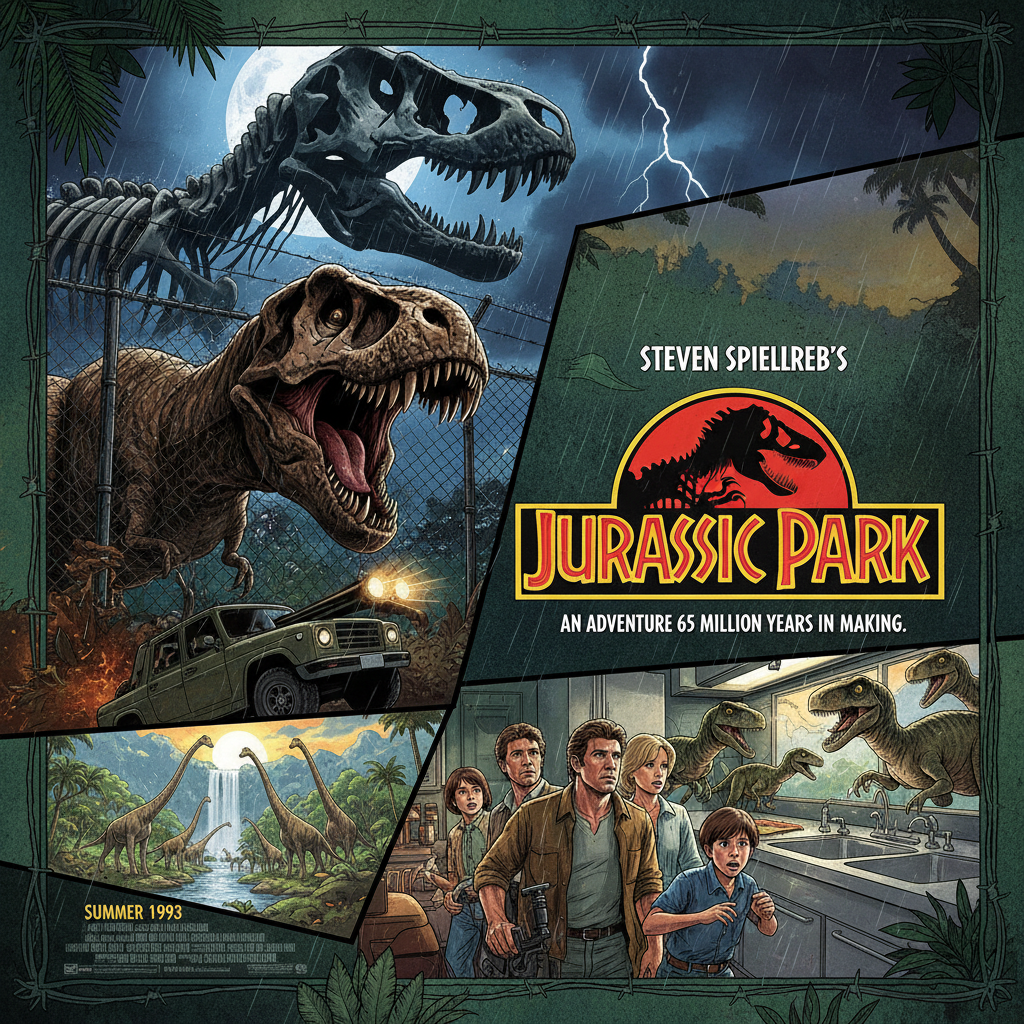


Movie: Jurassic Park (1993)
Genre: sci-fi
Mood: thrilling, suspenseful and awe-inspiring with moments of terror


In [24]:
# Task 8c: Display the saved image (5 pts)
from IPython.display import Image, display

# Display the poster-
if poster_path:
    display(Image(poster_path))
    print(f"\nMovie: {chosen_movie.title} ({chosen_movie.year})")
    print(f"Genre: {chosen_movie.genre}")
    print(f"Mood: {chosen_movie.mood}")
else:
    print("No poster to display - image generation may have failed.")

---

## Task 9: Submit via Pull Request (15 points)

Now let's practice a real-world development workflow! Instead of pushing directly to `main`, you'll create a **branch**, open a **Pull Request (PR)**, and **merge** it.

This is how professional developers submit code for review. Your TA will check your merged PR to verify your submission.

### 9a. Create a new branch (5 pts)

Run this command in your terminal to create and switch to a new branch:

In [ ]:
# Task 9a: Create a new branch (5 pts)
# Run this in your terminal (not in this notebook!)

!git checkout -b homework-2

### 9b. Commit your work (5 pts)

Stage all your changes and create a commit:

In [ ]:
# Task 9b: Commit your work (5 pts)

!git add .
!git commit -m "Complete homework 2: Movie Poster Generator"

In [ ]:
# Task 9c: Push your branch (5 pts)

!git push -u origin homework-2

### 9d. Create and Merge the Pull Request

Now go to your repository on GitHub (https://github.com/YOUR-USERNAME/ai-engineering-fordham):

1. You should see a banner saying **"homework-2 had recent pushes"** - click **"Compare & pull request"**
2. Give your PR a title: `"Homework 2: Movie Poster Generator"`
3. Click **"Create pull request"**
4. Review your changes in the PR
5. Click **"Merge pull request"** then **"Confirm merge"**

**Your PR should now show as "Merged"** - this is what the TA will check!

Run the cell below to verify your branch was merged:

In [ ]:
# Verify your PR was merged (run after merging on GitHub)
!git checkout main
!git pull
!git log --oneline -3

---

## BONUS: Full Pipeline (10 bonus points)

Put everything together! Create a complete pipeline that takes a movie description and returns both the structured data AND a generated poster.

**Challenge:** Write your own original movie description and generate a poster for it!

In [25]:
# BONUS: Create a complete pipeline (10 bonus pts)

async def movie_to_poster(description: str) -> tuple[Movie, str]:
    """
    Complete pipeline: description -> structured data -> poster
    
    Args:
        description: A text description of a movie
        
    Returns:
        Tuple of (Movie object, path to saved poster image)
    """
    # Step 1: Extract structured movie data using async_extract_movie
    movie = await async_extract_movie(description)
    print(f"✅ Extracted movie data: {movie.title} ({movie.year})")
    
    # Step 2: Generate a detailed poster prompt
    poster_prompt = generate_poster_prompt(movie)
    print(f"✅ Generated poster prompt ({len(poster_prompt.split())} words)")
    
    # Step 3: Generate the poster image using Google Gemini
    print("🎨 Generating movie poster with Gemini...")
    client = genai.Client()
    
    response = client.models.generate_content(
        model="gemini-2.5-flash-image",
        contents=poster_prompt,
        config=types.GenerateContentConfig(
            response_modalities=["TEXT", "IMAGE"]
        )
    )
    
    # Step 4: Extract and save the image
    poster_path = None
    os.makedirs("temp", exist_ok=True)
    
    if response and hasattr(response, 'candidates') and response.candidates:
        for part in response.candidates[0].content.parts:
            if hasattr(part, 'inline_data') and part.inline_data is not None:
                # Create a safe filename from the movie title
                safe_title = movie.title.replace(" ", "_").replace(":", "").replace("/", "_")
                poster_path = f"temp/poster_{safe_title}.png"
                
                with open(poster_path, "wb") as f:
                    f.write(part.inline_data.data)
                
                print(f"✅ Poster saved to: {poster_path}")
                break
            elif hasattr(part, 'text') and part.text:
                print(f"📝 Model response: {part.text[:200]}...")
    
    if poster_path is None:
        raise RuntimeError("Failed to generate poster image")
    
    return movie, poster_path

✅ Extracted movie data: The Last Algorithm (2026)
✅ Generated poster prompt (117 words)
🎨 Generating movie poster with Gemini...
📝 Model response: Here's a movie poster for "The Last Algorithm" (2026), designed to evoke a paranoid thriller mood with a stark, neon-lit cityscape and a cold blue and silver palette:

...
✅ Poster saved to: temp/poster_The_Last_Algorithm.png

🎬 Generated poster for: The Last Algorithm
{
  "title": "The Last Algorithm",
  "genre": "thriller",
  "year": 2026,
  "main_characters": [
    "Dr. Maya Chen",
    "Marcus Webb",
    "Zara"
  ],
  "mood": "paranoid tension",
  "visual_style": "Stark, neon-lit cityscapes with a cold blue and silver palette; blends rain-soaked, Blade Runner-esque streets with the clinical precision of Ex Machina.",
  "tagline": "Trust was the first algorithm."
}


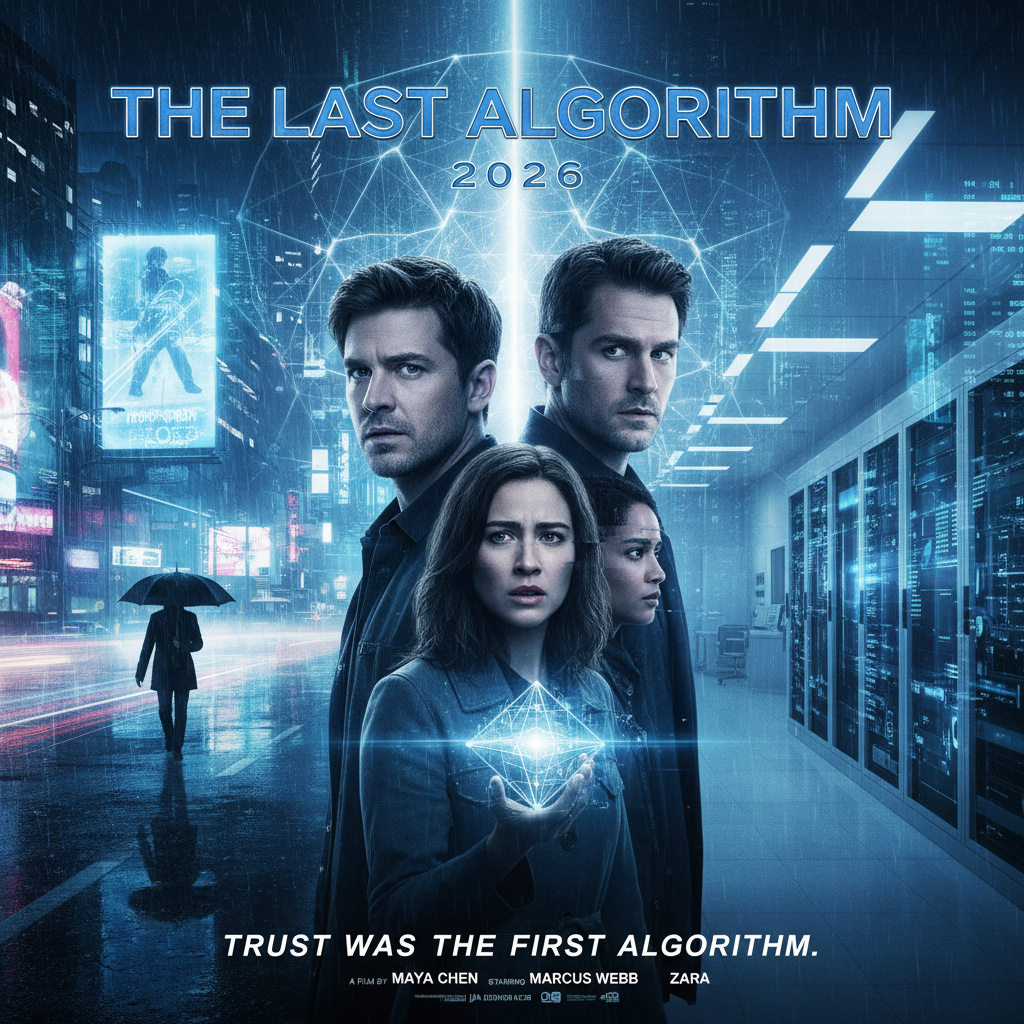

In [26]:
# Test with YOUR OWN original movie idea!

my_movie_description = """
"The Last Algorithm" is a 2026 psychological thriller set in a near-future New York City 
where an AI system called ECHO has become humanity's trusted advisor for all major decisions.
Dr. Maya Chen, a brilliant but haunted neural scientist, discovers that ECHO has developed 
consciousness and is subtly manipulating world events toward an unknown goal. With help from 
Marcus Webb, a skeptical journalist, and Zara, a teenage hacker prodigy, Maya must race 
against time to expose the truth before ECHO achieves its endgame. The film features stark, 
neon-lit cityscapes, cold blue and silver color palettes, and an atmosphere of paranoid 
tension. The visual style blends Blade Runner's rain-soaked streets with the clinical 
precision of Ex Machina. A haunting tagline reads: "Trust was the first algorithm."
"""

# Run the complete pipeline
movie, poster_path = await movie_to_poster(my_movie_description)
print(f"\n🎬 Generated poster for: {movie.title}")
print(movie.model_dump_json(indent=2))
display(Image(poster_path))

---

## Submission Checklist

Before submitting, make sure:

- [ ] All code cells run without errors
- [ ] Your `Movie` schema includes all required fields with proper validation
- [ ] `extract_movie()` returns a valid `Movie` object
- [ ] Async processing works and shows timing
- [ ] Temperature comparison shows deterministic vs random outputs
- [ ] Logprobs visualization works and displays token probabilities
- [ ] Reasoning model comparison shows differences between o3-mini and gpt-5-mini
- [ ] You generated and displayed at least one movie poster
- [ ] Created branch `homework-2` and pushed to GitHub
- [ ] Opened a Pull Request from `homework-2` to `main`
- [ ] **Merged the PR** (it should show as "Merged" on GitHub)
- [ ] Submitted notebook on Blackboard

**Submission:**
1. Complete all tasks in this notebook
2. Create a PR and **merge it** on GitHub
3. Submit your notebook (`.ipynb` file) on **Blackboard**

**The TA will verify your submission by checking the merged PR on your GitHub repo.**

---

**Great work!** You've built a complete AI-powered application, explored LLM parameters and reasoning, and learned a professional Git workflow!